In [187]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit
from importlib import reload

# Import from BB analysis github
import HopFinder
import HOP
import LC
import LC_Set

# COSI Analysis

## Daily

In [133]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'daily'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [160]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 22 #Counts / s


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        background_counts = COSI_bkg_rate * duration
        integral = np.sum(temp_sum)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,integral,duration]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral,duration,background_counts]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts)
    
    return mdp99

In [158]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]/100

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,2]
        background_counts = flarestack[:,3]

        COSI_BAND = np.array([flarenames, flareintegrals,flareduration,background_counts]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_daily_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_daily_df.columns=['Name','Photon Counts','Duration (s)','Background Counts']

COSI_BAND_ALL_daily_df


0
9.96e-07 6.39e-09 9.8961e-07 9.896100000000001e-08 1.05351e-07
<class 'list'>
 
[['0' '0' '0' '0']
 ['4FGL J0538.8-4405' '8.01767808' '25531200.0' '561686400.0']
 ['4FGL J0538.8-4405' '32.26073184' '81388800.0' '1790553600.0']
 ['4FGL J0538.8-4405' '9.00528192' '56246400.0' '1237420800.0']
 ['4FGL J0538.8-4405' '1.94819904' '16848000.0' '370656000.0']
 ['4FGL J0538.8-4405' '0.98467488' '8035200.0' '176774400.0']
 ['4FGL J0538.8-4405' '2.6540265599999997' '22939200.0' '504662400.0']
 ['4FGL J0538.8-4405' '1.4440291200000002' '14644800.0' '322185600.0']
 ['4FGL J0538.8-4405' '2.1941020799999995' '10238400.0' '225244800.0']
 ['4FGL J0538.8-4405' '8.858471040000001' '47952000.0' '1054944000.0']
 ['4FGL J0538.8-4405' '0.53034912' '3888000.0' '85536000.0']
 ['4FGL J0538.8-4405' '1.5995232' '8812800.0' '193881600.0']
 ['4FGL J0538.8-4405' '9.3453264' '38620800.0' '849657600.0']]
aaaaaaa
[  0.         150.20711668 604.38838569 168.70937179  36.4985171
  18.44738254  49.72183632  27.05315035 

,Name,Photon Counts,Duration (s),Background Counts
0,0,0,0,0
1,0,0.0,0,0
2,4FGL J0538.8-4405,150.20711668253008,25531200.0,561686400.0
3,4FGL J0538.8-4405,604.388385690174,81388800.0,1790553600.0
4,4FGL J0538.8-4405,168.70937179315118,56246400.0,1237420800.0
...,...,...,...,...
735,4FGL J0428.6-3756,0.3445793415740104,518400.0,11404800.0
736,4FGL J0428.6-3756,7.202721707548504,7516800.0,165369600.0
737,4FGL J0428.6-3756,6.56052040526204,7257600.0,159667200.0
738,4FGL J0428.6-3756,2.5556301166739104,3888000.0,85536000.0


In [ ]:
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df['Photon Counts']= COSI_BAND_ALL_daily_df['Photon Counts'].astype(float)
COSI_BAND_ALL_daily_df['Duration (days)'] = COSI_BAND_ALL_daily_df['Duration (s)'].astype(float)/(86400)
COSI_BAND_ALL_daily_df['MDP99'] = ComputeMDP99(COSI_BAND_ALL_weekly_df['Photon Counts'],COSI)


#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
COSI_BAND_ALL_daily_df

,Name,Photon Counts,Duration (s),Background Counts,Duration (days)
0,4FGL J0538.8-4405,150.207117,25531200.0,561686400.0,295.5
1,4FGL J0538.8-4405,604.388386,81388800.0,1790553600.0,942.0
2,4FGL J0538.8-4405,168.709372,56246400.0,1237420800.0,651.0
3,4FGL J0538.8-4405,36.498517,16848000.0,370656000.0,195.0
4,4FGL J0538.8-4405,18.447383,8035200.0,176774400.0,93.0
...,...,...,...,...,...
578,4FGL J0428.6-3756,0.344579,518400.0,11404800.0,6.0
579,4FGL J0428.6-3756,7.202722,7516800.0,165369600.0,87.0
580,4FGL J0428.6-3756,6.560520,7257600.0,159667200.0,84.0
581,4FGL J0428.6-3756,2.555630,3888000.0,85536000.0,45.0


In [137]:
print(COSI_BAND_ALL_daily_df.dtypes)

Name             object
Photons         float64
Duration (s)    float64
dtype: object


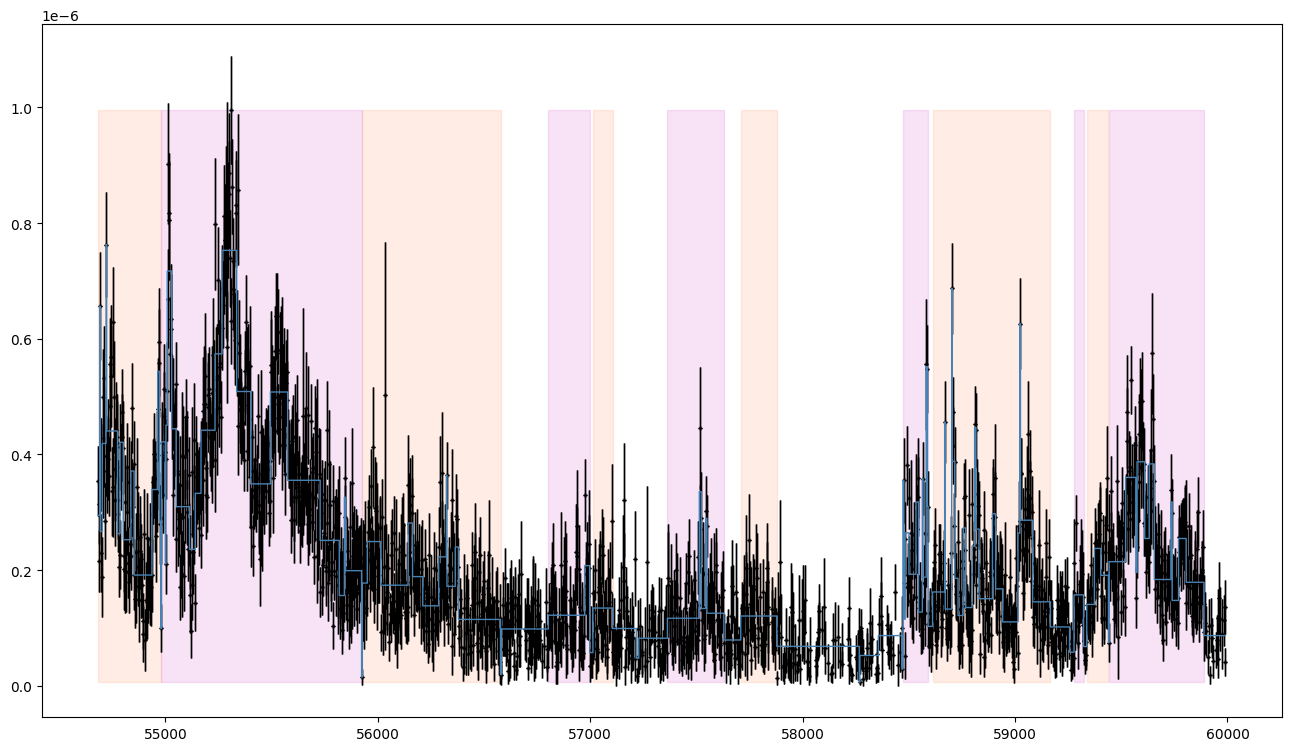

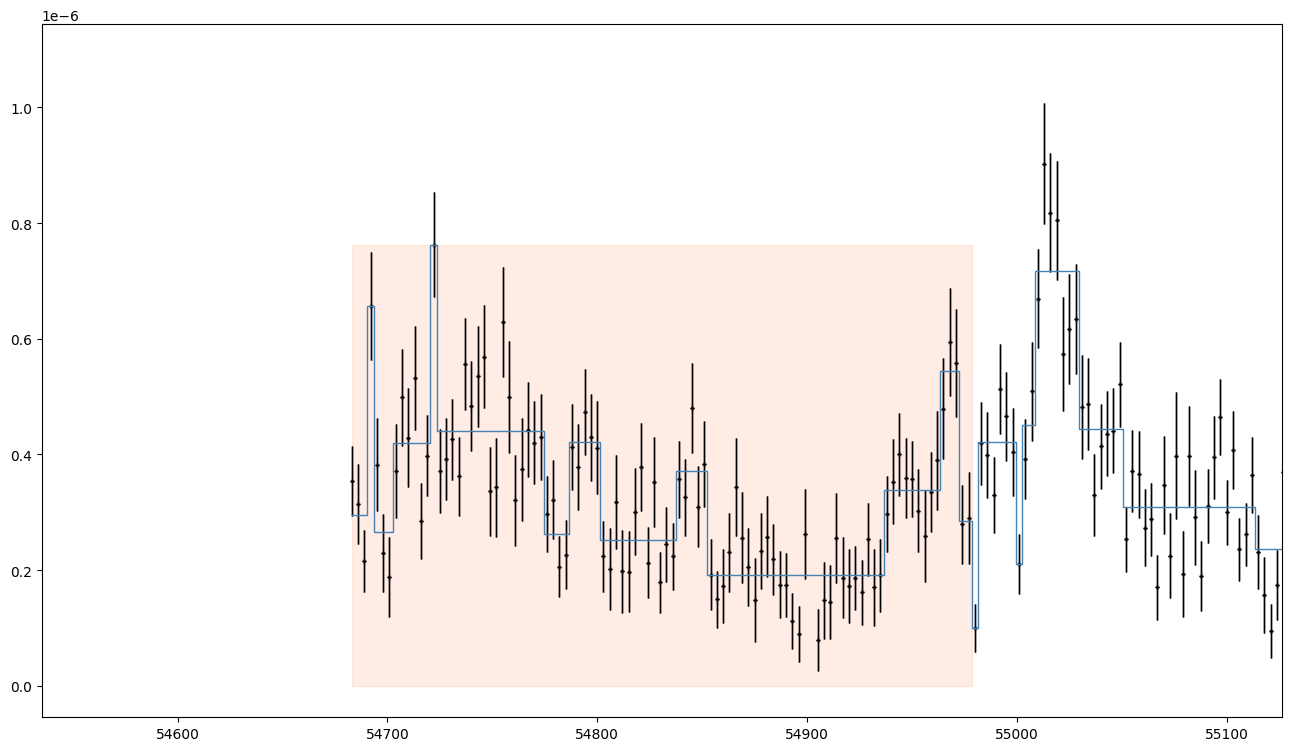

In [138]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [139]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3.  1.  3.  6.  1. 17.  4.  5. 12.  5. 27.  9.  3.  2.  1.  6.  1.  2.
  7.  7. 21.  9.  9. 22. 11. 23. 22. 31. 27. 50. 30.  8.  2. 25.  1.  8.
 21. 42.  7. 14. 22. 12.  1. 13.  5. 59.  1. 61. 50.  8.  5. 29. 30.  3.
 32. 45.  3.  6.  2. 22. 22. 47. 62.  1. 19. 16.  1.  1.  2.  5. 11.  4.
  6.  1.  5.  2.  1.  7. 19.  1.  9.  1.  4.  5.  8.  4. 10.  4.  2.  5.
 21.  5. 11. 24.  3.  1. 19. 26. 26.  5. 14.  5. 12. 10. 12.  1. 26. 16.
  2. 12.  7.  8. 26.  2. 10. 12. 28. 19.]


In [140]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54684.50001157, 54687.50001157, 54690.50001157, 54693.50001157,
       54696.50001157, 54699.50001157, 54702.50001157, 54705.50001157,
       54708.50001157, 54711.50001157, 54714.50001157, 54717.50001157,
       54720.50001157, 54723.50001157, 54726.50001157, 54729.50001157,
       54732.50001157, 54735.50001157, 54738.50001157, 54741.50001157,
       54744.50001157, 54747.50001157, 54750.50001157, 54753.50001157,
       54756.50001157, 54759.50001157, 54762.50001157, 54765.50001157,
       54768.50001157, 54771.50001157, 54774.50001157, 54777.50001157,
       54780.50001157, 54783.50001157, 54786.50001157, 54789.50001157,
       54792.50001157, 54795.50001157, 54798.50001157, 54801.50001157,
       54804.50001157, 54807.50001157, 54810.50001157, 54813.50001157,
       54816.50001157, 54819.50001157, 54822.50001157, 54825.50001157,
       54828.50001157, 54831.50001157, 54834.50001157, 54837.50001157,
       54840.50001157, 54843.50001157, 54846.50001157, 54849.50001157,
      

## Weekly

In [113]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [416]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 1


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        integral = np.sum(temp_sum)
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts) * 100
    
    return mdp99

Quiescent Background: 1.0996713584183675e-06, Error: 3.33365101553243e-09


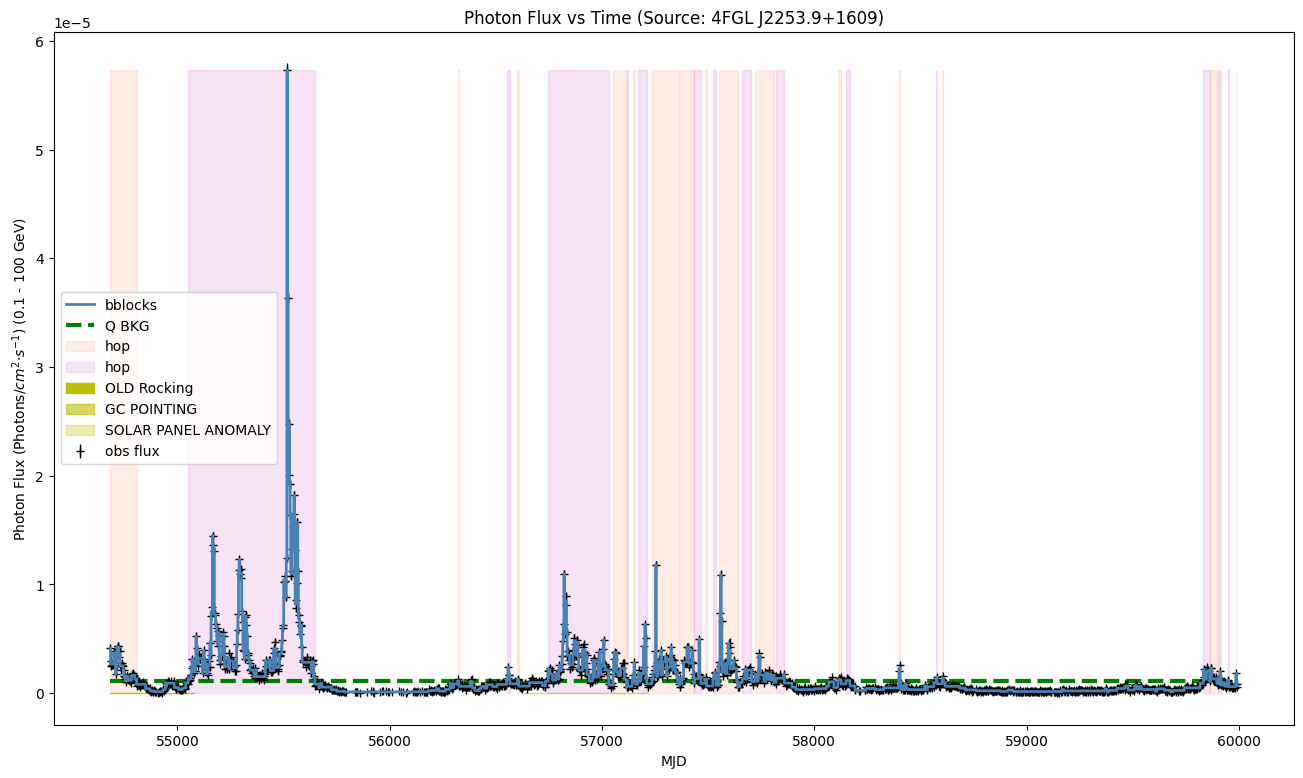

In [417]:
quiescent_flare_plot(cadence_df,sourcename=COSI_LAT_Sources['Name'][11],)

In [418]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
        flareflux = flarestack[:,1].astype(float)*factor
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,3]
        background_counts = flarestack[:,4]

        COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts']

COSI_BAND_ALL_weekly_df


0
9.96e-07 6.39e-09 9.8961e-07 9.896100000000001e-08 1.05351e-07
<class 'list'>
 
[['0' '0' '0' '0' '0']
 ['4FGL J0538.8-4405' '3.09324e-05' '8.01767808' '25531200.0'
  '25531200.0']
 ['4FGL J0538.8-4405' '0.0001244627' '32.26073184' '81388800.0'
  '81388800.0']
 ['4FGL J0538.8-4405' '3.47426e-05' '9.00528192' '56246400.0'
  '56246400.0']
 ['4FGL J0538.8-4405' '7.5162e-06' '1.94819904' '16848000.0' '16848000.0']
 ['4FGL J0538.8-4405' '3.7988999999999993e-06' '0.98467488' '8035200.0'
  '8035200.0']
 ['4FGL J0538.8-4405' '1.02393e-05' '2.6540265599999997' '22939200.0'
  '22939200.0']
 ['4FGL J0538.8-4405' '5.5711e-06' '1.4440291200000002' '14644800.0'
  '14644800.0']
 ['4FGL J0538.8-4405' '8.464900000000001e-06' '2.1941020799999995'
  '10238400.0' '10238400.0']
 ['4FGL J0538.8-4405' '3.41762e-05' '8.858471040000001' '47952000.0'
  '47952000.0']
 ['4FGL J0538.8-4405' '2.0460999999999998e-06' '0.53034912' '3888000.0'
  '3888000.0']
 ['4FGL J0538.8-4405' '6.170999999999999e-06' '1.5995232' 

,Name,Photon Flux (ph/cm2/s),Photon Count,Duration (s),Background Counts
0,0,0,0,0,0
1,0,0.0,0.0,0,0
2,4FGL J0538.8-4405,1.0634672639762339e-05,210.46924325094176,25531200.0,25531200.0
3,4FGL J0538.8-4405,4.27907330294755e-05,846.8651084936503,81388800.0,81388800.0
4,4FGL J0538.8-4405,1.194463338293204e-05,236.3944837959605,56246400.0,56246400.0
...,...,...,...,...,...
735,4FGL J0428.6-3756,2.3792983506561147e-08,0.44714345910015846,518400.0,518400.0
736,4FGL J0428.6-3756,4.973433346503824e-07,9.346613423014192,7516800.0,7516800.0
737,4FGL J0428.6-3756,4.529997448013896e-07,8.51326076051478,7257600.0,7257600.0
738,4FGL J0428.6-3756,1.7646462767366186e-07,3.316313988326175,3888000.0,3888000.0


In [419]:
COSI_BAND_ALL_weekly_df = COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df[:]['Photon Count']!='0'].reset_index(drop=True)
COSI_BAND_ALL_weekly_df = COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_weekly_df['Photon Count']= COSI_BAND_ALL_weekly_df['Photon Count'].astype(float)
COSI_BAND_ALL_weekly_df['Duration (s)'] = COSI_BAND_ALL_weekly_df['Duration (s)'].astype(float)
COSI_BAND_ALL_weekly_df['Duration (weeks)'] = COSI_BAND_ALL_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_ALL_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_ALL_weekly_df['Photon Count'].astype(float),COSI_BAND_ALL_weekly_df['Background Counts'].astype(float))
COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_ALL_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_ALL_weekly_df['Duration (s)']



#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')
COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)', 'MDP99']
COSI_BAND_ALL_weekly_df[neworder].head(10)
COSI_BAND_ALL_weekly_df[neworder].sort_values('MDP99').head(10)


,Name,Photon Flux (ph/cm2/s),Fluence (ph/cm2),Photon Count,Background Counts,Duration (s),Duration (weeks),MDP99
418,4FGL J0224.9+1843,0.074152,2.932985e+07,1.636361e+06,395539200.0,395539200.0,654.000000,17.415994
85,4FGL J2253.9+1609,0.002416,1.690540e+04,5.244159e+04,6998400.0,6998400.0,11.571429,72.407014
269,4FGL J1357.1+1921,0.009319,2.525473e+06,2.064838e+05,270993600.0,270993600.0,448.071429,114.049930
344,4FGL J0405.6-1308,0.003545,1.442439e+05,7.862659e+04,40694400.0,40694400.0,67.285714,116.132318
343,4FGL J0405.6-1308,0.010350,3.675409e+06,2.295921e+05,355104000.0,355104000.0,587.142857,117.407897
553,4FGL J2232.6+1143,0.001385,1.041205e+04,3.028987e+04,7516800.0,7516800.0,12.428571,129.696558
83,4FGL J2253.9+1609,0.000469,1.092963e+03,1.017132e+04,2332800.0,2332800.0,3.857143,215.199944
82,4FGL J2253.9+1609,0.000468,1.091548e+03,1.015815e+04,2332800.0,2332800.0,3.857143,215.478456
561,4FGL J2232.6+1143,0.000711,4.606679e+03,1.554558e+04,6480000.0,6480000.0,10.714286,234.442773
554,4FGL J2232.6+1143,0.000263,4.086813e+02,5.746357e+03,1555200.0,1555200.0,2.571429,310.911974


Text(0, 0.5, 'Number of Sources')

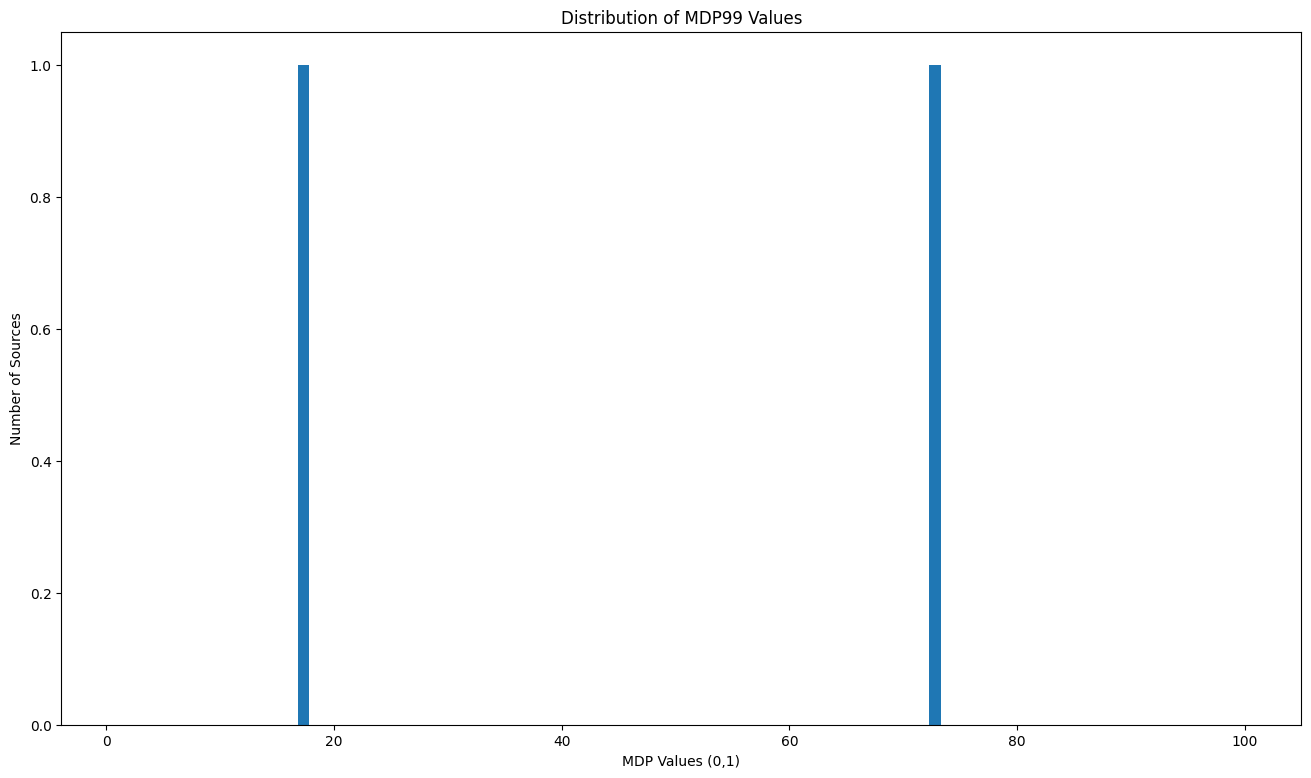

In [420]:
#COSI_BAND_ALL_weekly_df.to_csv('COSI_BAND_ALL_weekly_0bkg.csv')
plt.figure(figsize=(16,9))
plt.hist(COSI_BAND_ALL_weekly_df['MDP99'],bins=100,range=(1,100))
plt.title('Distribution of MDP99 Values')
plt.xlabel('MDP Values (0,1)')
plt.ylabel('Number of Sources')

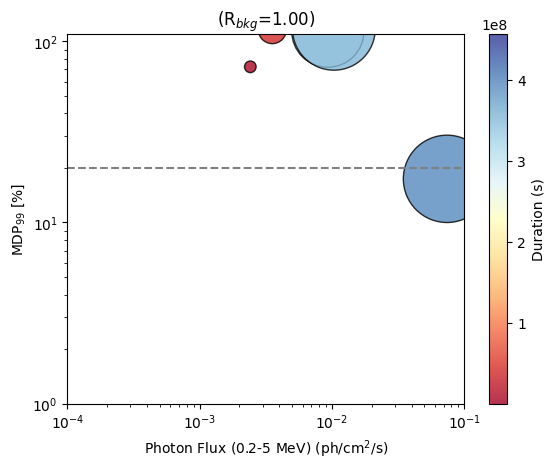

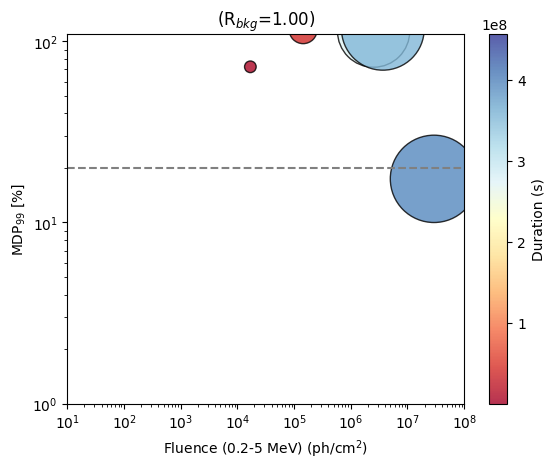

In [421]:
#plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'])
plt.figure()
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_ALL_weekly_df['Duration (s)']
sc = plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'],c=z, s=COSI_BAND_ALL_weekly_df['Duration (s)']*1e-5, cmap=cm,alpha = 0.8,edgecolors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Duration (s)')
plt.ylim(1,110)
plt.xlim(1e-4,1e-1)
plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.title(r'(R$_{bkg}$=%.2f)'%COSI_bkg_rate)
plt.savefig('Diagrams/COSI_Flux_v_MDP99_Rbkg%.2f.png'%COSI_bkg_rate, dpi=200)


plt.figure()
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_ALL_weekly_df['Duration (s)']
sc = plt.scatter(COSI_BAND_ALL_weekly_df['Fluence (ph/cm2)'],COSI_BAND_ALL_weekly_df['MDP99'],c=z, s=COSI_BAND_ALL_weekly_df['Duration (s)']*1e-5, cmap=cm, alpha =0.8,edgecolors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Duration (s)')
plt.hlines(20,10,1e+8,colors='0.5',linestyles='dashed',label='20% MDP')
plt.xscale('log')
plt.yscale('log')
plt.title(r'(R$_{bkg}$=%.2f)'%COSI_bkg_rate)
plt.ylim(1,110)
plt.xlim(10,1e+8)
plt.xlabel(r'Fluence (0.2-5 MeV) (ph/cm$^2$)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.savefig('Diagrams/COSI_Fluence_v_MDP99_Rbkg%.2f.png'%COSI_bkg_rate, dpi=200)

In [152]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
i=0
print(i)
Aeff = 70

sourcename = '4FGL J2253.9+1609'

factor = COSI_LAT_Sources[COSI_LAT_Sources['Name']=='4FGL J2253.9+1609']

sourcearray = cadence_df[cadence_df['source_name'] == '4FGL J2253.9+1609'].reset_index(drop=True)
titlestring=sourcename

sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2']
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent
print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

hops_bl = sourcelightcurve.hops
print(type(hops_bl))

if type(hops_bl) != list:
    print('bleh')

else:
    flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
    print(' ')
    print(flarestack)
    print('aaaaaaa')

    flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
    print(flareintegrals)
    print('bbbbbbbbbbbbb')
    flarenames = flarestack[:,0]
    print(flarenames)
    flareduration = flarestack[:,2]

    COSI_BAND = np.array([flarenames, flareintegrals,flareduration]).T
    print(COSI_BAND)
    print(COSI_BAND_ALL)
    COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_weekly_df.columns=['Name','Photon Count','Duration (s)']

COSI_BAND_ALL_weekly_df


0
5.73e-05 3.19e-09 5.729681e-05 5.729681e-06 5.7328710000000005e-06
<class 'list'>
 
[['0' '0' '0']
 ['4FGL J2253.9+1609' '19.98432' '2332800.0']
 ['4FGL J2253.9+1609' '20.010240000000003' '2332800.0']
 ['4FGL J2253.9+1609' '3.6884159999999997' '777600.0']
 ['4FGL J2253.9+1609' '103.169376' '6998400.0']
 ['4FGL J2253.9+1609' '1.63296' '518400.0']
 ['4FGL J2253.9+1609' '1.640736' '518400.0']
 ['4FGL J2253.9+1609' '2.104704' '518400.0']
 ['4FGL J2253.9+1609' '0.0' '259200.0']
 ['4FGL J2253.9+1609' '0.0' '259200.0']
 ['4FGL J2253.9+1609' '4.745952000000001' '777600.0']]
aaaaaaa


ValueError: Unable to coerce to Series, length must be 3: given 11

In [ ]:
COSI_LAT_Sources[COSI_LAT_Sources['Name']='4FGL J2253.9+1609'

,Name,ph/s_ratio,Aeff_mean(cm2)
0,4FGL J2253.9+1609,0.343804,5449.182919
1,4FGL J2253.9+1609,1.202340,5913.637940
2,4FGL J2253.9+1609,0.426944,5964.610300
3,4FGL J2253.9+1609,0.000527,6993.495144
4,4FGL J2253.9+1609,0.009530,6523.682940
...,...,...,...
60,4FGL J2253.9+1609,1.820678,5533.541922
61,4FGL J2253.9+1609,0.514739,5460.844580
62,4FGL J2253.9+1609,8.482368,5195.910851
63,4FGL J2253.9+1609,0.298478,5247.438973


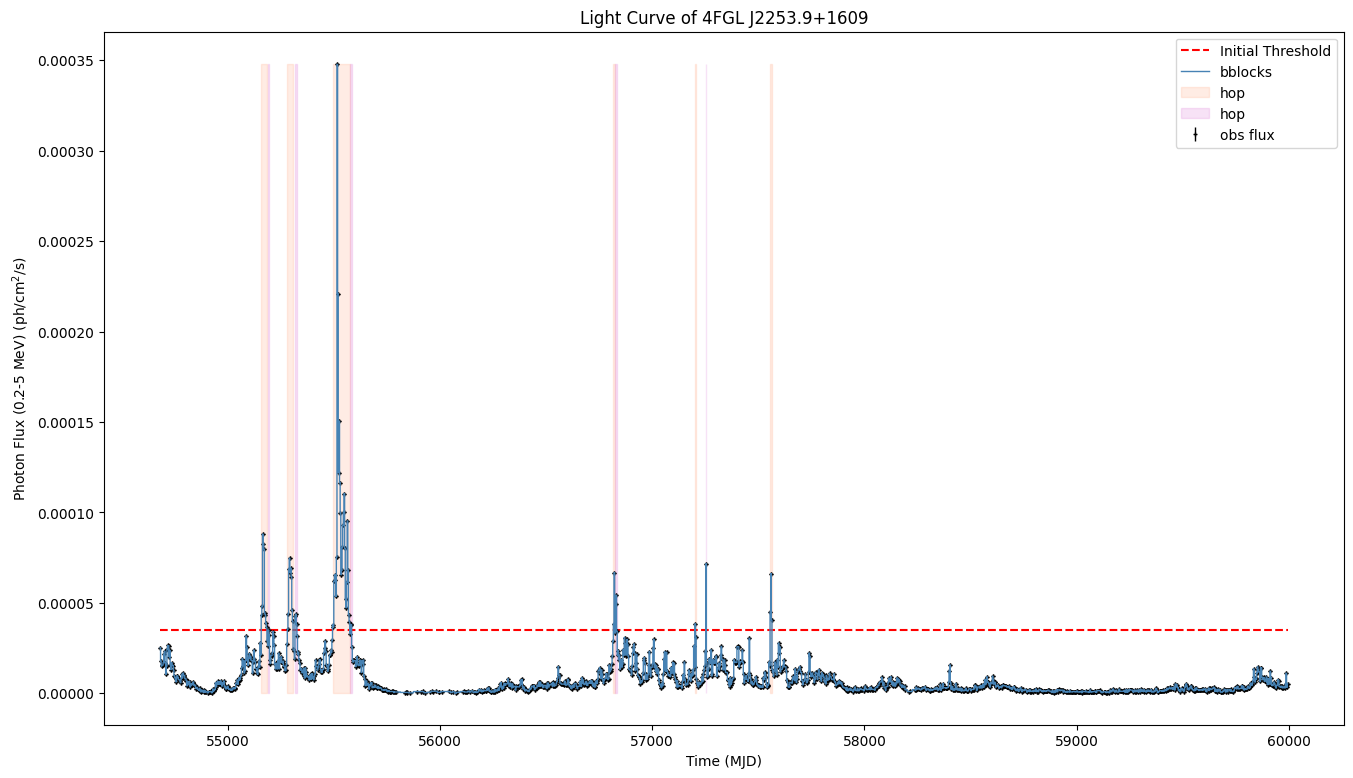

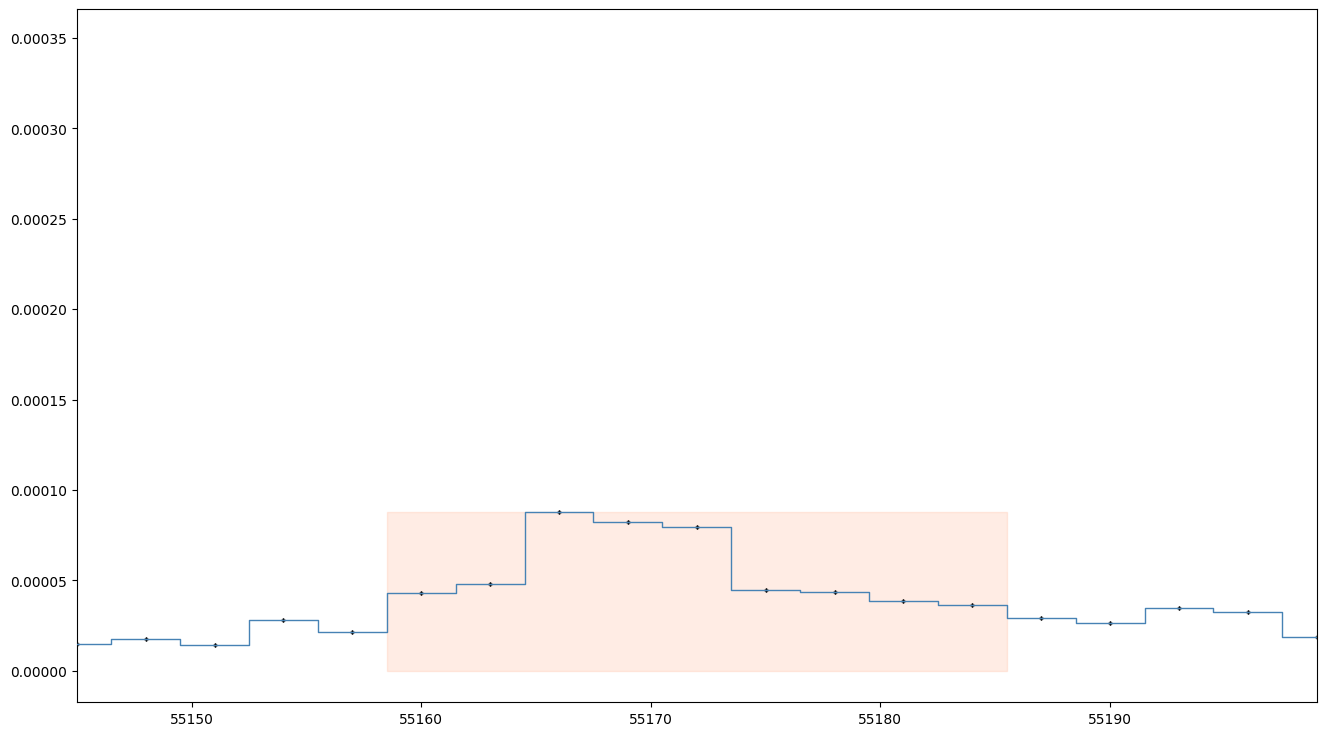

In [374]:
p = 11
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = COSI_LAT_Sources['ph/s_ratio'][p]
percent = 0.1
Aeff = 70
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
plt.hlines(thresholdflux,xmin=np.min(sourcelightcurve.time),xmax=np.max(sourcelightcurve.time),label='Initial Threshold',colors='red',linestyles='dashed')
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()
plt.title('Light Curve of ' +str(titlestring))
plt.ylabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.xlabel('Time (MJD)')
plt.legend()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


Quiescent Background: 1.0996713584183675e-06, Error: 3.33365101553243e-09


/var/folders/td/mm4slxv90412jt0yh0zz6zgw0000gp/T/ipykernel_58257/3296036800.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


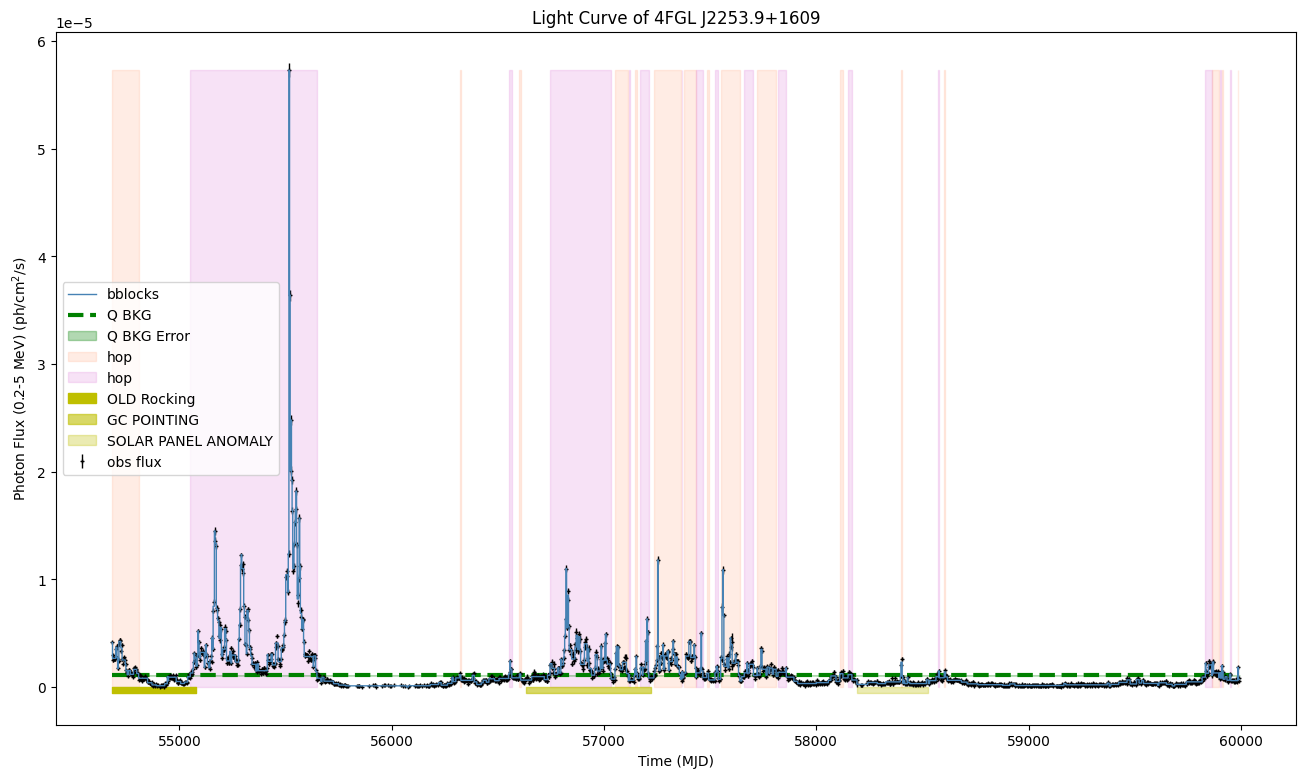

In [373]:

percent = 0.1 
MJDREFI=51910 
MJDREFF=7.428703703703703e-4
bkg_err = True 
factor = 1
# Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.




sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

#if sourcelightcurve.hops == None:
#    print("No flares detected for "+str(titlestring))
#    return None


# Finding quiescent background.
quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


# Using quiescent background to find flares again.
sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


#sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
sourcelightcurve.get_bblocks(gamma_value=0.05)
#sourcelightcurve.get_bblocks_above(threshold = 0)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)



# Plotting the Lightcurve itself.
plt.figure(figsize=(16,9))
plt.title('Light Curve of ' +str(titlestring))
plt.ylabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.xlabel('Time (MJD)')
plt.legend()

sourcelightcurve.plot_bblocks(size=1)
sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

if bkg_err == True:
    y1 = quiescent_background + qui_err
    y2 = quiescent_background - qui_err
    plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

sourcelightcurve.plot_hop()
plotting_anomalies()
plt.legend()



In [104]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3. 11.  1.  2.  8. 11.  4.  2.  1.  4.  3.  4.  8.  2.  7.  6.  7.  7.
  4.  8. 13. 12. 21. 12. 21.  8. 19.  3.  7. 10. 13.  2.  4. 16. 36. 23.
  4. 15. 14.  6. 27.  7.  1.  8. 44.  8.  8. 35. 13.  9.  1.  5.  1. 11.
  1.  4.  2.  3.  3.  2.  4.  5.  8.  3.  5. 10.  1.  1.  8. 13.  3.  8.
  3.  7.  2.  5. 21.  9.  3.  8. 16.  5. 12. 13.]


In [105]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54686.50001157, 54693.50001157, 54700.50001157, 54707.50001157,
       54714.50001157, 54721.50001157, 54728.50001157, 54735.50001157,
       54742.50001157, 54749.50001157, 54756.50001157, 54763.50001157,
       54770.50001157, 54777.50001157, 54784.50001157, 54791.50001157,
       54798.50001157, 54805.50001157, 54812.50001157, 54819.50001157,
       54826.50001157, 54833.50001157, 54840.50001157, 54847.50001157,
       54854.50001157, 54861.50001157, 54868.50001157, 54875.50001157,
       54882.50001157, 54889.50001157, 54896.50001157, 54903.50001157,
       54910.50001157, 54917.50001157, 54924.50001157, 54931.50001157,
       54938.50001157, 54945.50001157, 54952.50001157, 54959.50001157,
       54966.50001157, 54973.50001157, 54980.50001157, 54987.50001157,
       54994.50001157, 55001.50001157, 55008.50001157, 55015.50001157,
       55022.50001157, 55029.50001157, 55036.50001157, 55043.50001157,
       55050.50001157, 55057.50001157, 55064.50001157, 55071.50001157,
      

## Monthly

In [106]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'Monthly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [107]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        integral = np.sum(temp_sum)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,integral,duration]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral,duration]))
    return flarestack


0
nan nan nan nan nan


IndexError: index -1 is out of bounds for axis 0 with size 0

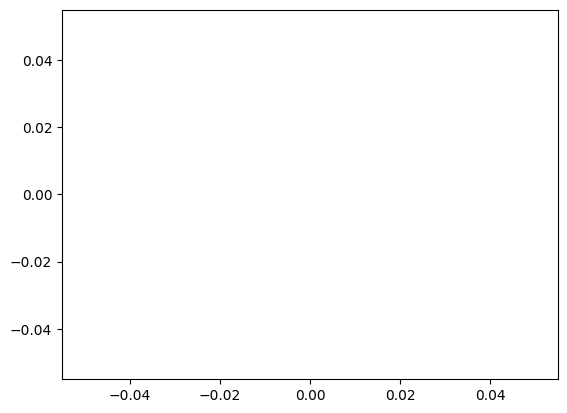

In [ ]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,2]

        COSI_BAND = np.array([flarenames, flareintegrals,flareduration]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_monthly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_monthly_df.columns=['Name','Photons','Duration (s)']

COSI_BAND_ALL_monthly_df


In [ ]:
COSI_BAND_ALL_monthly_df = COSI_BAND_ALL_monthly_df[COSI_BAND_ALL_monthly_df[:]['Photons']!='0'].reset_index(drop=True)
COSI_BAND_ALL_monthly_df = COSI_BAND_ALL_monthly_df[COSI_BAND_ALL_monthly_df[:]['Photons']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_monthly_df['Photons']= COSI_BAND_ALL_monthly_df['Photons'].astype(float)
COSI_BAND_ALL_monthly_df['Duration (s)'] = COSI_BAND_ALL_monthly_df['Duration (s)'].astype(float)
COSI_BAND_ALL_monthly_df

,Name,Photons,Duration (s)
0,4FGL J0538.8-4405,88244.455393,147268800.0
1,4FGL J0538.8-4405,2092.085690,9676800.0
2,4FGL J0538.8-4405,5633.924218,26611200.0
3,4FGL J0538.8-4405,818.070769,4233600.0
4,4FGL J0538.8-4405,6319.540038,34776000.0
...,...,...,...
463,4FGL J0428.6-3756,182.520074,3326400.0
464,4FGL J0428.6-3756,1540.798913,20563200.0
465,4FGL J0428.6-3756,1711.298122,19958400.0
466,4FGL J0428.6-3756,848.200067,10886400.0


In [ ]:
print(COSI_BAND_ALL_monthly_df.dtypes)

Name             object
Photons         float64
Duration (s)    float64
dtype: object


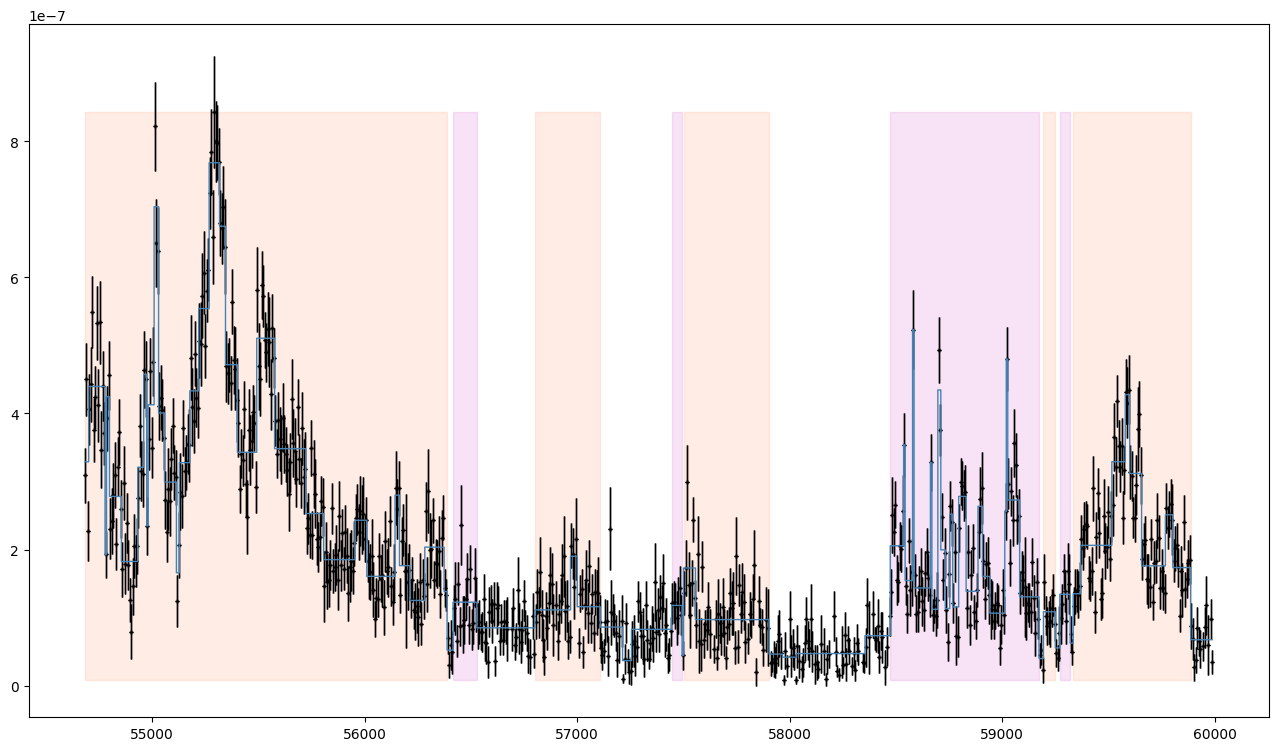

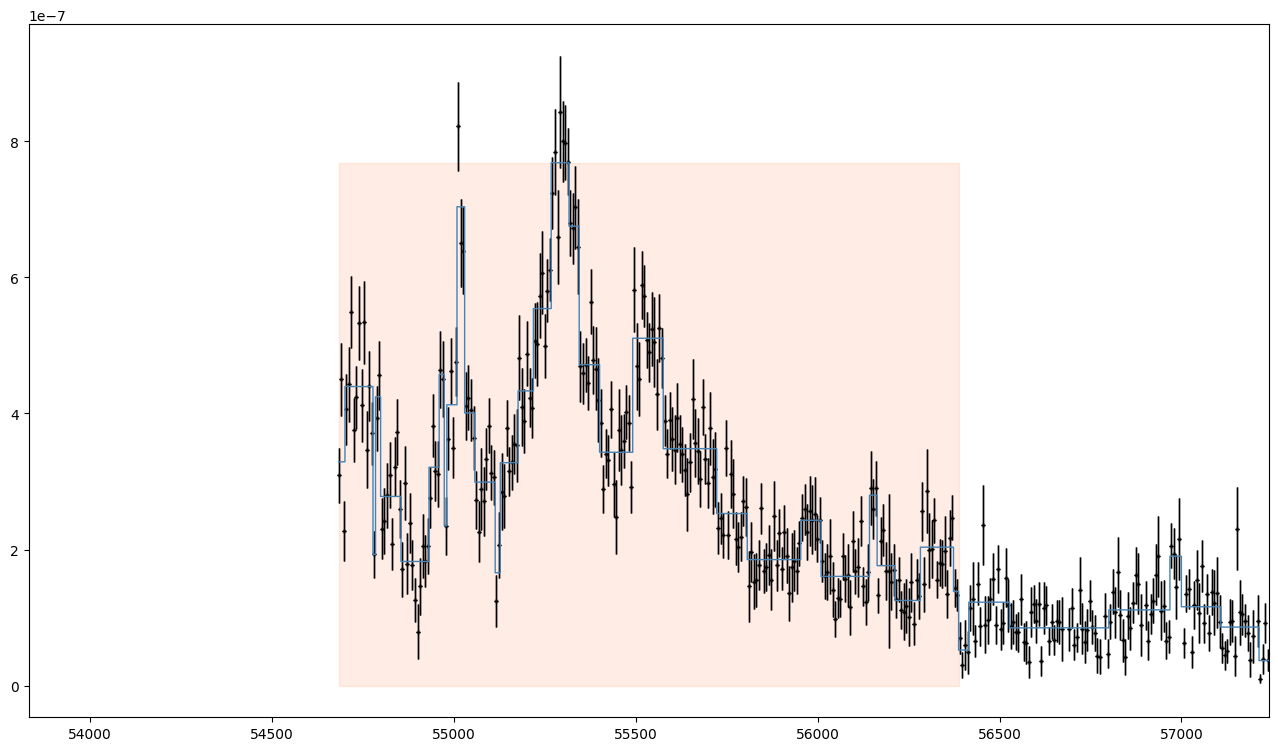

In [ ]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [ ]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3. 11.  1.  2.  8. 11.  4.  2.  1.  4.  3.  4.  8.  2.  7.  6.  7.  7.
  4.  8. 13. 12. 21. 12. 21.  8. 19.  3.  7. 10. 13.  2.  4. 16. 36. 23.
  4. 15. 14.  6. 27.  7.  1.  8. 44.  8.  8. 35. 13.  9.  1.  5.  1. 11.
  1.  4.  2.  3.  3.  2.  4.  5.  8.  3.  5. 10.  1.  1.  8. 13.  3.  8.
  3.  7.  2.  5. 21.  9.  3.  8. 16.  5. 12. 13.]


In [ ]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54686.50001157, 54693.50001157, 54700.50001157, 54707.50001157,
       54714.50001157, 54721.50001157, 54728.50001157, 54735.50001157,
       54742.50001157, 54749.50001157, 54756.50001157, 54763.50001157,
       54770.50001157, 54777.50001157, 54784.50001157, 54791.50001157,
       54798.50001157, 54805.50001157, 54812.50001157, 54819.50001157,
       54826.50001157, 54833.50001157, 54840.50001157, 54847.50001157,
       54854.50001157, 54861.50001157, 54868.50001157, 54875.50001157,
       54882.50001157, 54889.50001157, 54896.50001157, 54903.50001157,
       54910.50001157, 54917.50001157, 54924.50001157, 54931.50001157,
       54938.50001157, 54945.50001157, 54952.50001157, 54959.50001157,
       54966.50001157, 54973.50001157, 54980.50001157, 54987.50001157,
       54994.50001157, 55001.50001157, 55008.50001157, 55015.50001157,
       55022.50001157, 55029.50001157, 55036.50001157, 55043.50001157,
       55050.50001157, 55057.50001157, 55064.50001157, 55071.50001157,
      